# Section 2.3

## Dataset creation
Created by randomly refining edges in a uniform triangular mesh for $8\times 8, 16\times 16, 32 \times 32$ and $64\times 64$ cells that are split into $2$ triangles as many times, so that no mesh is finer than the $64\times 64$ mesh.

In [4]:

from dolfinx import mesh as msh
from dolfinx import io
import torch
from mpi4py import MPI
import numpy as np

rng = np.random.default_rng()

def mesh_to_x(mesh, bK, device=None, dtype=None):
    lst = []
    for v in mesh.geometry.x[:,0:2][mesh.geometry.dofmap]:
        xK = np.concat((v[2]-v[1], v[2]-v[0], v[1]-v[0], bK), axis=None)
        lst.append(xK)

    xnp=np.array(lst).T
    return torch.tensor(xnp, requires_grad=False, device=device, dtype=dtype)

bK = np.array([1,0])

num = 0
# base meshes
for s in range(3):
    domain = msh.create_unit_square(MPI.COMM_WORLD, int(2**(s+2)), int(2**(s+2)), msh.CellType.triangle)
    with io.XDMFFile(domain.comm, f"data/example_2_1/training_set/fem_data/mesh_{num}.xdmf", "w") as writer:
        writer.write_mesh(domain)
    x = mesh_to_x(domain, bK)
    torch.save(x, f'data/example_2_1/training_set/inputs/x_{num}.pt')
    num += 1

for j in range(2): #sample 10 times overall
    for i in range(1,8): #iterate through 1/8, 2/8,..., 7/8 of all edges in the current mesh 
        for s in range(2): #iterate through 8 by 8, 16 by 16 base-mesh
            domain = msh.create_unit_square(MPI.COMM_WORLD, int(2**(s+2)), int(2**(s+2)), msh.CellType.triangle)
            for k in range(3-s): #refine so that no edge is smaller than in a 32 by 32 mesh
                domain.topology.create_entities(1)
                N = domain.topology.index_map(1).size_local
                edges = rng.choice(N, size=int(N*i/8), replace=False)
                domain = msh.refine(domain, edges)[0]
                with io.XDMFFile(domain.comm, f"data/example_2_1/training_set/fem_data/mesh_{num}.xdmf", "w") as writer:
                    writer.write_mesh(domain)
                x = mesh_to_x(domain, bK)
                torch.save(x, f'data/example_2_1/training_set/inputs/x_{num}.pt')
                num += 1


num = 0

for i in range(1,8):
    for s in range(2):
        domain = msh.create_unit_square(MPI.COMM_WORLD, int(2**(s+2)), int(2**(s+2)), msh.CellType.triangle)
        for k in range(3-s): 
            domain.topology.create_entities(1)
            N = domain.topology.index_map(1).size_local
            edges = rng.choice(N, size=int(N*i/8), replace=False)
            domain = msh.refine(domain, edges)[0]
            with io.XDMFFile(domain.comm, f"data/example_2_1/test_set/fem_data/mesh_{num}.xdmf", "w") as writer:
                writer.write_mesh(domain)
            x = mesh_to_x(domain, bK)
            torch.save(x, f'data/example_2_1/test_set/inputs/x_{num}.pt')
            num += 1


## Visualization of the meshes


In [ ]:
import pyvista as pv
import os
from dolfinx import fem, plot, io
from mpi4py import MPI

def plot_mesh(i):
    mesh_path = os.path.join("data/example_2_1/training_set/fem_data/", f"mesh_{i}.xdmf")
    with io.XDMFFile(MPI.COMM_WORLD, mesh_path, "r") as reader:
        mesh = reader.read_mesh()
    Wh = fem.functionspace(mesh, ('P', 1))
    c_topology, c_cell_types, c_geometry = plot.vtk_mesh(Wh)
    grid = pv.UnstructuredGrid(c_topology, c_cell_types, c_geometry)
    p.camera_position='xy'
    p.add_mesh(grid, show_edges=True)
    p.reset_camera()

p = pv.Plotter(notebook=True, shape=(2,2))



p.subplot(0,0)
p.add_text('1.')
plot_mesh(0)
p.zoom_camera(1.3)
p.subplot(0,1)
p.add_text('2.')
plot_mesh(4)
p.zoom_camera(1.3)
p.subplot(1,0)
p.add_text('3.')
plot_mesh(5)
p.zoom_camera(1.3)
p.subplot(1,1)
p.add_text('4.')
plot_mesh(6)
p.zoom_camera(1.3)
p.show()

## Dataloaders
objects that load a tensor that encodes mesh as the sides of each cell and initializes an fem solver for each datapoint.

In [3]:
import os
from dolfinx import io
from dolfinx import fem
from dolfinx import default_scalar_type
from dolfinx import mesh as msh
import ufl
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from mpi4py import MPI

from utils.FEniCSx_PyTorch_interface import FEniCSx_PyTorch_interface
from utils.FEniCSx_solver import FEniCSx_solver
import numpy as np

batch_size = 16
class fem_solver_class:
    def __init__(self, FEniCSx):
        self.autograd_func = FEniCSx_PyTorch_interface.apply
        self.FEniCSx = FEniCSx
    def __call__(self, weights):
        return self.autograd_func(weights, self.FEniCSx)

class Dataset_example_2_1(Dataset):
    def __init__(self, input_dir, mesh_dir):
        lst = os.listdir(input_dir)
        size = len([f for f in lst if f.endswith('.pt')])
        self.solvers = []

        for idx in range(size):
            input_path = os.path.join(input_dir, f"x_{idx}.pt")
            input = torch.load(input_path) 

            mesh_path = os.path.join(mesh_dir, f"mesh_{idx}.xdmf")
            with io.XDMFFile(MPI.COMM_WORLD, mesh_path, "r") as reader:
                mesh = reader.read_mesh()


            Wh = fem.functionspace(mesh, ('P', 1))
            mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)
            boundary_facets = msh.exterior_facet_indices(mesh.topology)
            boundary_dofs = fem.locate_dofs_topological(Wh, mesh.topology.dim-1, boundary_facets)
            bcs = [fem.dirichletbc(fem.Constant(mesh, default_scalar_type(0.0)), boundary_dofs, Wh)]

            eps = fem.Constant(mesh, default_scalar_type(1e-8))
            b = ufl.as_vector((fem.Constant(mesh, default_scalar_type(1.0)),fem.Constant(mesh, default_scalar_type(0.0))))
            f = fem.Constant(mesh, default_scalar_type(1.0))
            uh = fem.Function(Wh)

            x = ufl.SpatialCoordinate(mesh)

            cid_lims = mesh.topology.index_map(2).local_range
            marker_ids = np.arange(cid_lims[0], cid_lims[1])

            for index in range(cid_lims[0],cid_lims[1]):
                if np.intersect1d(Wh.dofmap.cell_dofs(index), bcs[0].dof_indices()[0]).size > 0:
                        marker_ids = marker_ids[marker_ids!=index]

            marker = np.ones_like(marker_ids, dtype=np.int32)
            cell_tag = msh.meshtags(mesh, mesh.topology.dim, marker_ids, marker)
            dx = ufl.Measure("dx", domain=mesh, subdomain_data=cell_tag, subdomain_id=1)

            residual = (ufl.dot(b, ufl.grad(uh)) - f)**2 * dx

            b_perp = ufl.conditional(ufl.eq(ufl.inner(b, b),0), b, -ufl.perp(b)/ufl.sqrt(ufl.inner(b,b)))
            cross = abs(ufl.dot(b_perp, ufl.grad(uh)))
            crosswind_loss = ufl.conditional(ufl.lt(cross, 1), 1/2*(5*cross**2 - 3*cross**3), ufl.sqrt(cross)) * dx

            loss = residual + crosswind_loss
            pde_data = mesh,Wh,uh,eps,b,None,f,None,bcs

            FEniCSx = FEniCSx_solver(pde_data=pde_data, loss_form=loss)
            fs = fem_solver_class(FEniCSx=FEniCSx)
            self.solvers.append({'x': input, 'fem_solver': fs})
    def __len__(self):
        return len(self.solvers)

    def __getitem__(self, idx):
        return self.solvers[idx]
    
def collate_fn(batch):
    B = [b for b in batch]
    return B

train_dataset = Dataset_example_2_1(input_dir="data/example_2_1/training_set/inputs/", mesh_dir="data/example_2_1/training_set/fem_data/")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

test_dataset = Dataset_example_2_1(input_dir="data/example_2_1/test_set/inputs/", mesh_dir="data/example_2_1/test_set/fem_data/")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

## Naive model
A single layer perceptron that inferrs the optimal element size from a simple toy model.

In [4]:
class model(torch.nn.Module):
    def __init__(self, device, dtype, dir= None):
        super().__init__()
        self.w = torch.nn.Parameter(torch.rand(8, device=device, dtype=dtype, requires_grad=True))
        if dir is not None:
            self.load_state_dict(torch.load(dir, weights_only=True))

    
    def forward(self, x):
        a = torch.sqrt(x[0]**2+x[1]**2)
        b = torch.sqrt(x[2]**2+x[3]**2)
        c = torch.sqrt(x[4]**2+x[5]**2)
        s = (a+b+c)/2
        A = torch.sqrt(s*((s-a)*(s-b)*(s-c)))
        h_K = 4*A/torch.sqrt(a**2+b**2+c**2)
        limit = h_K**2/(1e-8*48)
        low = torch.zeros_like(limit)
        z1 = torch.matmul(self.w, x)
        Pe = z1/(2*1e-8)
        z2 = z1/2*(1/torch.tanh(Pe)-(2*1e-8)*z1)
        supg_params = torch.clip(z2, min = low, max=limit)
        return supg_params

In [ ]:

import numpy as np
import torch
import time

def test_loop(dataloader, nn):
    nn.eval()
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for batch, (B) in enumerate(dataloader):
            batch_size = len(B)
        for idx in range(batch_size):
            x, fem_solver = B[idx]['x'], B[idx]['fem_solver']
            batch_size = len(B)
            for idx in range(batch_size):
            # Compute prediction and loss
                z2 = nn(x)
                test_loss += 1/batch_size*fem_solver(z2).item()

    test_loss /= num_batches
    print(f"Test Error: {test_loss:>8f} \n")
    return(test_loss)


def test(dataloader, model, model_nm, epochs, dtype, device, test_loss_file):
    test_loss_array = np.array([])
    for idx in range(epochs):
        nn = model(device=device, dtype=dtype, dir=f"{model_nm}_{idx}.pth")
        print(f"Epoch {idx+1}\n-------------------------------")
        test_loss_array = np.append(test_loss_array,test_loop(dataloader,  nn))

    np.save(file=test_loss_file, arr=test_loss_array)


def train_loop(dataloader, nn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    nn.train()
    train_loss = 0
    for batch, (B) in enumerate(dataloader):
        agg_loss = 0
        batch_size = len(B)
        for idx in range(batch_size):
            x, fem_solver = B[idx]['x'], B[idx]['fem_solver']
        # Compute prediction and loss
            z2 = nn(x)
            loss = 1/batch_size*fem_solver(z2)
            loss.backward()
            agg_loss += loss.item()
        # Backpropagation
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = agg_loss, batch * batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        train_loss += agg_loss
    train_loss /= num_batches
    print(f"train_loss: {train_loss:>7f}")
    return(train_loss)



def train(model_dir, model_init, optim, scheduler, dtype, device, epochs, train_loss_file):
    nn = model(device=device, dtype=dtype, dir=model_init)
    optimizer = optim(nn.parameters())
    scheduler = scheduler(optimizer)
    train_loss_array = np.array([])
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        loss = train_loop(train_loader, nn, optimizer)
        train_loss_array = np.append(train_loss_array, loss)
        scheduler.step(loss)
        torch.save(nn.state_dict(), f'{model_dir}_{t}.pth')

    np.save(file=train_loss_file, arr=train_loss_array)




input = train_dataset[0]['x']
start = time.perf_counter()

start = time.perf_counter()
train(
         model_dir='data/example_2_1/models/nn_exact_Adam',
         model_init='data/example_2_1/models/nn_init.pth',
         optim=torch.optim.Adam,
         scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
         dtype=input.dtype,
         device=input.device,
         epochs=10000,
         train_loss_file='data/example_2_1/exact_train_loss_Adam.npy'
         )

t1 = time.perf_counter() - start
print(f"Example 2.1: 20 epochs with SGD took {t1:.3f} seconds")

test(   
        dataloader=test_loader,
        model=model,
        model_nm='data/example_2_1/models/nn_exact_Adam',
        epochs=10000,
        dtype=input.dtype,
        device=input.device,
        test_loss_file='data/example_2_1/exact_test_loss_Adam.npy'
        )
print("Done!")




In [24]:
from dolfinx import mesh as msh, plot
from mpi4py import MPI
import pyvista as pv


mesh = msh.create_unit_square(comm=MPI.COMM_WORLD, nx=1, ny=1, cell_type=msh.CellType.triangle)


u, v = mesh.geometry.x[:,0:2][mesh.geometry.dofmap]
print(v, np.concat((v[2]-v[1], v[2]-v[0], v[1]-v[0]), axis=None))
Wh = fem.functionspace(mesh, ('P', 1))
c_topology, c_cell_types, c_geometry = plot.vtk_mesh(Wh)
grid = pv.UnstructuredGrid(c_topology, c_cell_types, c_geometry)
p=pv.Plotter()
p.camera_position='xy'
p.add_mesh(grid, show_edges=True)
p.reset_camera()
p.show()

nn=model(device='cpu', dtype=torch.float32, dir="data/example_2_1/models/nn_exact_Adam_9999.pth" )
w = list(nn.parameters())[0]
w

[[0. 0.]
 [0. 1.]
 [1. 1.]] [1. 0. 1. 1. 0. 1.]


Widget(value='<iframe src="http://localhost:49753/index.html?ui=P_0x334033750_5&reconnect=auto" class="pyvista…

Parameter containing:
tensor([-0.3051, -0.0741, -0.0531, -0.5845, -0.2417, -0.3418,  7.8133,  0.9380],
       requires_grad=True)

## Loss over 20 epochs
compares the loss for the Adam and SGD optimizer over 20 epochs

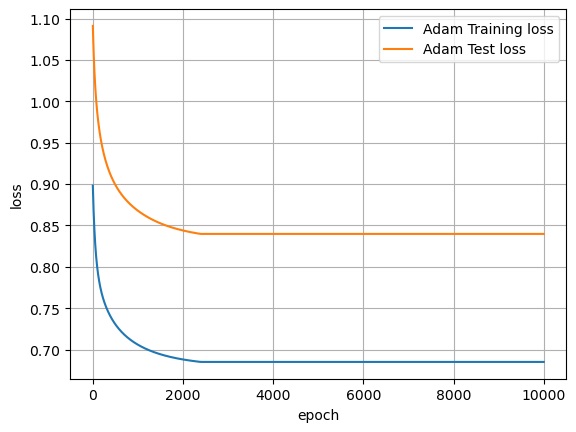

In [1]:
import numpy as np
import matplotlib.pyplot as plt


Adam_train_loss = 'data/example_2_1/exact_train_loss_Adam.npy'
Adam_test_loss = 'data/example_2_1/exact_test_loss_Adam.npy'



Adam_train_loss = np.load(Adam_train_loss)
Adam_test_loss = np.load(Adam_test_loss)


x= np.linspace(1,len(Adam_train_loss),len(Adam_train_loss))

plt.plot(x, Adam_train_loss, label= 'Adam Training loss', linestyle='-',)
plt.plot(x, Adam_test_loss,label='Adam Test loss', linestyle='-')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.savefig('example_2_1_loss.png')
plt.show()